This notebook contains the first experiments I made to familiarize myself with the data. My goal was to plot histograms of the repartition of peak sizes in the different samples.

In [1]:
### Import necessary libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tk

In [2]:
%%html

<style>
    /* Jupyter */
    .rendered_html table,
    /* Jupyter Lab*/
    div[data-mime-type="text-markdown"] table {
        margin-left: 0
    }
  
    td {
        font-size: 16px
    }
    
</style>

In [3]:
### Fix directories

data_dir = "../data/initial database/output" #path to project folder

os.chdir(data_dir) #Select the project directory


<p style = "font-size:16px;">
    The data is imported in a single dataframe as follows, where the .csv are stored themselves as pandas dataframes.
</p>





|sample      | compounds    | peaks         | spectra         |
| :--------- | :----------- | :------------ | :-------------- |
| DiAcids    | compound.csv | ms2_peaks.csv | ms2_spectra.csv |
| Fallopia   | ...          |               |                 |
| Ruthenium  |              |               |                 |
| Ruthenium2 |              |               |                 |

In [4]:
### Import the data from the csv files

def select_directory(sample, file_name = "compounds", part = 1):
    """Returns the file directory corresponding to the file_name.csv file in the folder corresponding to the given sample
    (DiAcids, Fallopia, Ruthenium or Ruthenium2).
    
    the input part indicates the subfolder in which it is stored (pt1 or pt2)."""
    return data_dir + "/" + sample + "/pt" + str(part) + "/" + file_name + ".csv"

def df_from_csv(directory):
    """Extracts the csv file of the file contained in the directory and stores it in a pandas dataframe."""
    with open(directory) as file:
        return pd.read_csv(file)
    
def data_wir(sample):
    """Return a dataframe containing the data of ms2_spectra and an additional column "intratio" of
    the ratios ms2 peak intensity / sum of the intensities in the same ms2 spectrum.
    
    Note : wir means "with intratio" """
    
    #Read the csv files (there are two in this case, one in pt1 and one in pt2)
    df_compounds = df_from_csv(select_directory(sample))
    df_peaks = df_from_csv(select_directory(sample, file_name = "ms2_peaks"))
    
    #Adds the intensities of the peaks having the same spectrum_id.
    sums =  df_peaks.groupby("spectrum_id")["intensity"].sum()
    
    #Generate the intratio column.
    intratio = [df_peaks.intensity[i] / sums[df_peaks.spectrum_id[i]] for i in df_peaks.index]
    
    #Insert the intratio column into the dataframe
    df_peaks["intratio"] = intratio
    
    print("Completed conversion of " + sample)
    
    return df_peaks

#Convert the data into pandas dataframes and compute intratios.

sample_names = ["DiAcids", "Fallopia", "Ruthenium", "Ruthenium2"]

data = pd.DataFrame({"sample" : sample_names,
                     "compounds" : [df_from_csv(select_directory(sample)) for sample in sample_names],
                     "peaks" : [data_wir(sample) for sample in sample_names],
                     "spectra" : [df_from_csv(select_directory(sample, file_name = "ms2_spectra")) for sample in sample_names]
                    })
data.index = sample_names

Completed conversion of DiAcids
Completed conversion of Fallopia
Completed conversion of Ruthenium
Completed conversion of Ruthenium2


In [5]:
# Code for generating the histograms.

def histo_simple(df, sample):
    splits = np.logspace(-4.5, 0, 40)
    
    df["intratio"].hist(bins = splits, grid = False, color = "#FF9917", edgecolor = "#000000")
    plt.xscale("log")
    ax = plt.gca()
    ax.xaxis.set_minor_locator(tk.NullLocator())
    plt.title("Observed distribution of peak sizes in the " + sample + " sample")
    plt.xlabel("intensity ratio")


def histo_ir(df, title = "",  xmin = -4.5, bins = 200, show = False, border = False, grid = True, color = "#FF9917", alpha = 1, label = ""):
    """Plots an histogram of the count of intratio values in #bins intervals evenly spaced in logarithmic scale, starting from 10^-xmin. If precise_ticks is set to True, manage the ticks of the x-axis so it coincides with the edges of the bars in the histogram. If center_ticks is set to True, the labels will be displayed at the center of the bins instead of at the edges."""
    
    #Generates the list of values delimiting the intervals.
    splits = np.logspace(xmin, 0, bins + 1)
    
    #Generate the plot in color (default : orange) with or without black borders (default : without)
    if border:
        bcolor = "#000000"
    else:
        bcolor = None
        
    df["intratio"].hist(bins = splits, grid = grid, color = color, edgecolor = bcolor, alpha = alpha, label = label)
    
    
    #Last aesthetic adjustments.
    plt.xscale("log")
    ax = plt.gca()
    ax.xaxis.set_minor_locator(tk.NullLocator())
    
    if title:
        plt.title(title)

  
    
def compare_histo(df1, df2, title = "", bins = 76, label1 = "df1", label2 = "df2"):
    """Plots on the same graphic the peaks size histograms for df1 in orange and df2 in blue."""
    histo_ir(df1, bins = bins, alpha = .75, label = label1)
    histo_ir(df2, bins = bins, color = "#003DFF", alpha = .5, label = label2)
    plt.legend()
    
    if title:
        plt.title(title)

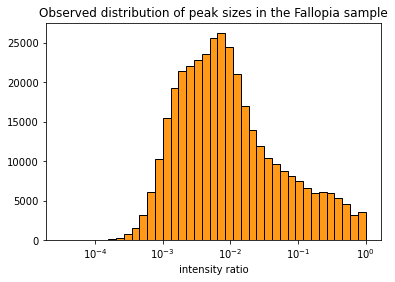

In [6]:
# Examples of histo_simple
histo_simple(data.peaks["Fallopia"], "Fallopia")

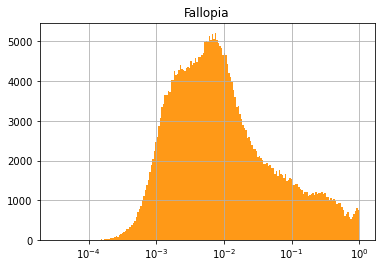

In [7]:
#Example of histo_ir with default settings
histo_ir(data.peaks["Fallopia"], "Fallopia")

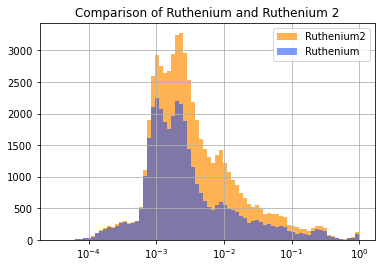

In [8]:
#Example of compare histo for a comparison between Ruthenium and Ruthenium2
compare_histo(data.peaks["Ruthenium2"],
              data.peaks["Ruthenium"],
              title = "Comparison of Ruthenium and Ruthenium 2",
              label1 = "Ruthenium2",
              label2 = "Ruthenium"
             )

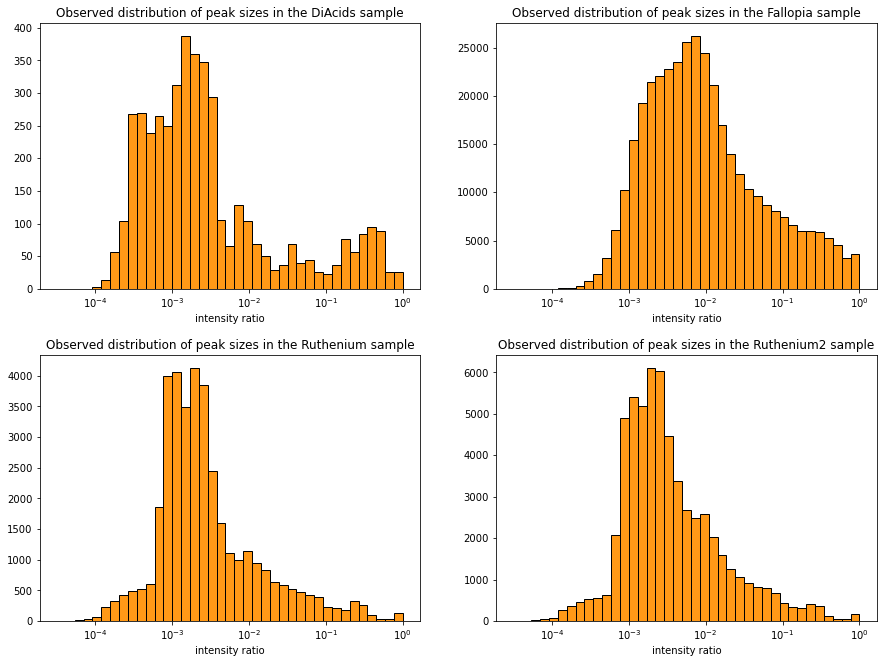

In [9]:
#Output of histo_simple for the 4 samples.
plt.figure(figsize = (15, 11))

for i in range(4):
    sample = sample_names[i]
    plt.subplot(2, 2, i + 1)
    histo_simple(data.peaks[sample], sample)

plt.subplots_adjust(hspace = .25)

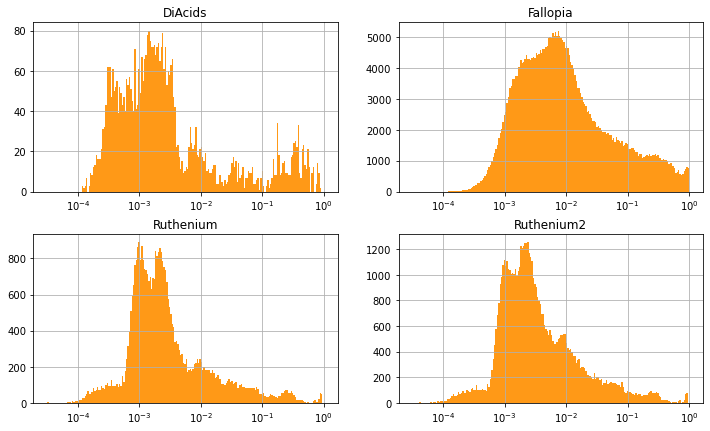

In [10]:
#Output of histo_ir for the 4 samples.
plt.figure(figsize = (12, 7))

for i in range(4):
    sample = data["sample"][i]
    plt.subplot(2, 2, i + 1)
    histo_ir(data["peaks"][sample], data["sample"][sample])

plt.subplots_adjust(hspace = .25)

In [11]:
#Pre-processing functions for comparing the peak size distributions between well-identified compounds and the unknown ones.

def get_lowmq(sample, threshold = .85, dontwantzero = True):
    mq = data.compounds[sample].groupby("compound_id")["compound_mq"].first()

    sp_id = data.spectra[sample].groupby("spectrum_id")["compound_id"].first()
    
    if dontwantzero:
        bool_list = [
            mq[sp_id[spectrum_id]] < threshold
            and mq[sp_id[spectrum_id]] > 1e-3
            for spectrum_id in data.peaks[sample]["spectrum_id"]
        ]
    else:
        bool_list = [(mq[sp_id[spectrum_id]] < threshold) for spectrum_id in data.peaks[sample]["spectrum_id"]]
        
    return data.peaks[sample].loc[bool_list]

def get_highmq(sample, threshold = .85):
    mq = data.compounds[sample].groupby("compound_id")["compound_mq"].first()

    sp_id = data.spectra[sample].groupby("spectrum_id")["compound_id"].first()

    bool_list = [(mq[sp_id[spectrum_id]] > threshold) for spectrum_id in data.peaks[sample]["spectrum_id"]]
    
    return data.peaks[sample].loc[bool_list]

In [12]:
#Divides the data into three groups : mq = 0 (unidentified, 0 < mq < 0.85 (probably misidentified)
#and mq>0.85 (probably assigned to the right compound)

sample_except_da = sample_names[1:]

mq_groups = pd.DataFrame({
    "sample" : sample_except_da,
    "unidentified" : [get_lowmq(sample, threshold = 1e-3, dontwantzero = False) for sample in sample_except_da],
    "lowmq" : [get_lowmq(sample) for sample in sample_except_da],
    "highmq" : [get_highmq(sample) for sample in sample_except_da]
    })

mq_groups.index = sample_except_da

#Add the concatenation of lowmq and unidentified.
mq_groups["all_lowmq"] = [pd.concat((mq_groups["unidentified"][sample],
                                    mq_groups["lowmq"][sample])
                                   )
                          for sample in sample_except_da]

In [13]:
# Compare the compounds which have been assigned a label those those which haven't.

def compare_wrt_mq(sample, lowmq_column = "lowmq"):
    compare_histo(mq_groups[lowmq_column][sample],
                  mq_groups["highmq"][sample],
                  title = "Comparison between well-identified compound and badly-identified compounds for " + sample,
                  label1 = "mq < 0.85",
                  label2 = "mq > 0.85"
                 )

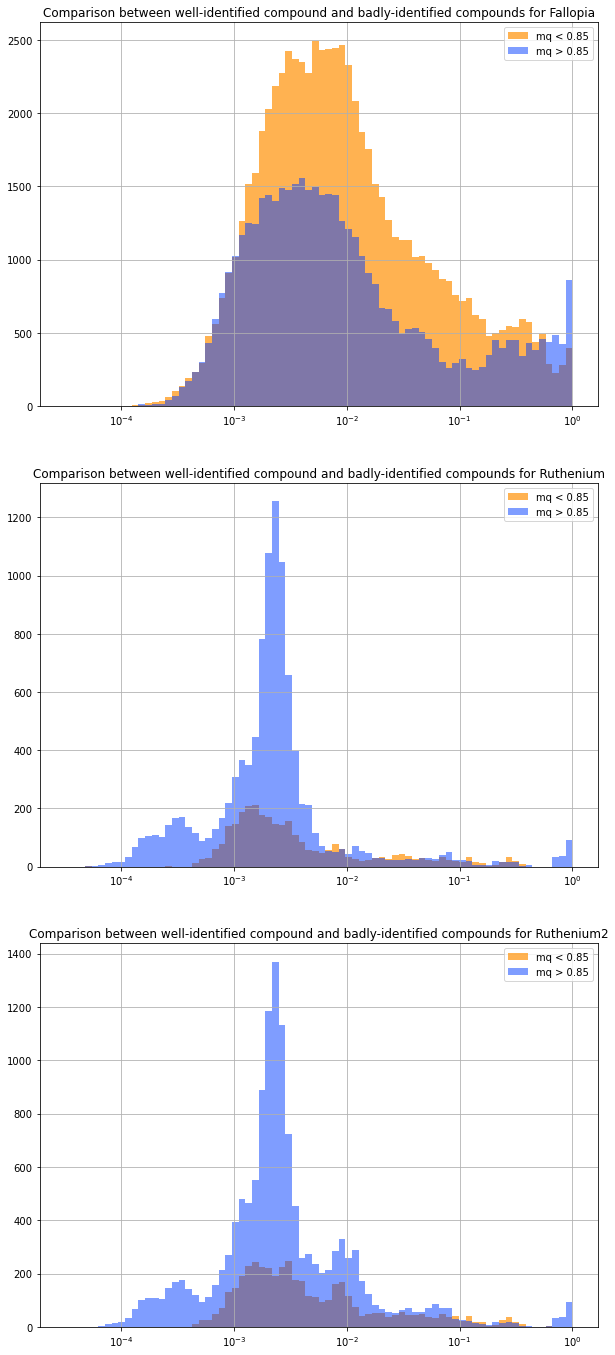

In [14]:
#Output of compare_wrt_mq for Fallopia, Ruthenium and Ruthenium2 (DiAcids is irrelevant because it is the test sample).

plt.figure(figsize = (10, 24))

for i in range(1, 4):
    plt.subplot(3, 1, i)
    compare_wrt_mq(sample_names[i])

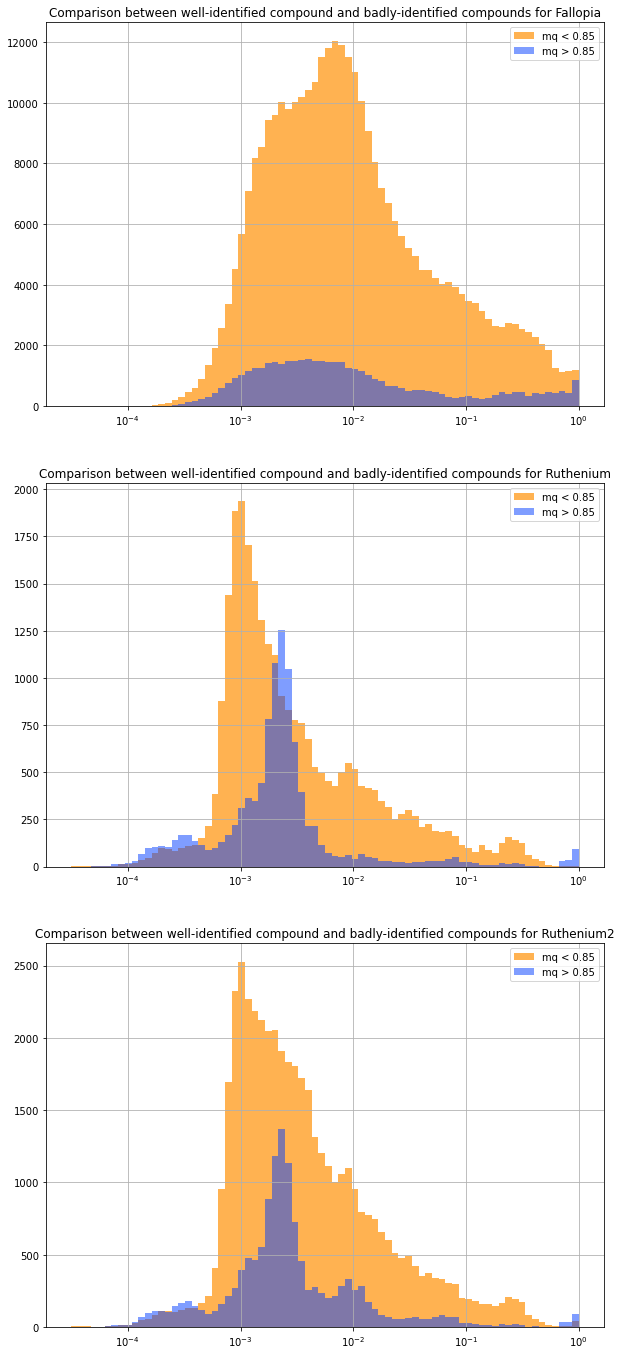

In [15]:
#Do the same but with all_lowmq instead of only lowmq.

plt.figure(figsize = (10, 24))

for i in range(1, 4):
    plt.subplot(3, 1, i)
    compare_wrt_mq(sample_names[i], lowmq_column = "all_lowmq")

In [16]:
def histo_fi(df, title = "",  xmin = -4.5, bins = 200, show = False, border = False, grid = True, color = "#FF9917", alpha = 1, label = ""):
    """Plots an histogram of the count of intratio values in #bins intervals evenly spaced in logarithmic scale, starting from 10^-xmin. If precise_ticks is set to True, manage the ticks of the x-axis so it coincides with the edges of the bars in the histogram. If center_ticks is set to True, the labels will be displayed at the center of the bins instead of at the edges."""
    
    #Generates the list of values delimiting the intervals
    splits = np.logspace(np.log(250) / np.log(10), np.log(df["intensity"].max())/ np.log(10), bins + 1)
    
    #Generate the plot in color (default : orange) with or without black borders (default : without)
    if border:
        bcolor = "#000000"
    else:
        bcolor = None
        
    df["intensity"].hist(bins = splits, grid = grid, color = color, edgecolor = bcolor, alpha = alpha, label = label)
    
    
    #Last aesthetic adjustments.
    plt.xscale("log")
    ax = plt.gca()
    ax.xaxis.set_minor_locator(tk.NullLocator())
    
    if title:
        plt.title(title)
    

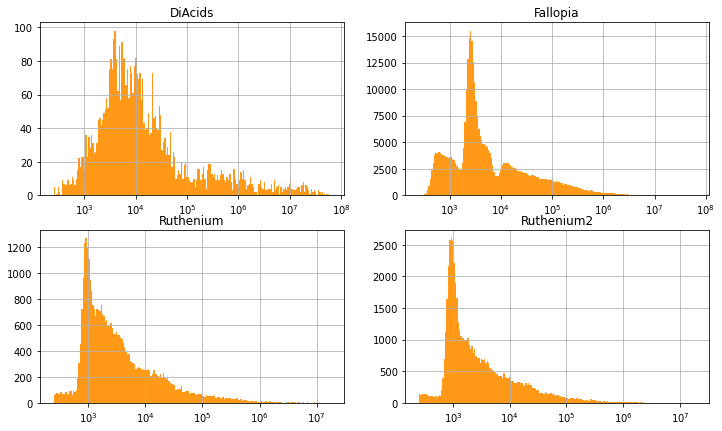

In [17]:
plt.figure(figsize = (12, 7))

for i in range(4):
    plt.subplot(2, 2, i + 1)
    histo_fi(data["peaks"][sample_names[i]], sample_names[i])

In [18]:
def histo_ir_norm(df, title = "",  xmin = -4.5, bins = 200, show = False, border = False, grid = True, color = "#FF9917", alpha = 1, label = ""):
    """Plots an histogram of the count of intratio values in #bins intervals evenly spaced in logarithmic scale, starting from 10^-xmin. If precise_ticks is set to True, manage the ticks of the x-axis so it coincides with the edges of the bars in the histogram. If center_ticks is set to True, the labels will be displayed at the center of the bins instead of at the edges."""
    
    #Generates the list of values delimiting the intervals.
    splits = np.linspace(-4.5, 0, bins + 1)
    
    #Generate the plot in color (default : orange) with or without black borders (default : without)
    if border:
        bcolor = "#000000"
    else:
        bcolor = None
    
    sery = np.log(df["intratio"]) / np.log(10)
    sery.hist(bins = splits,
              grid = grid,
              color = color,
              edgecolor = bcolor,
              alpha = alpha,
              label = label,
              density = True)
    
    
    #Last aesthetic adjustments.
    plt.xticks([-4, -3, -2, -1, 0])
    
    ax = plt.gca()
    ax.set_xticklabels(["1e-4", "1e-3", "1e-2","1e-1", "1"])
    ax.xaxis.set_minor_locator(tk.NullLocator())
    
    if title:
        plt.title(title)

  
    
def compare_histo_norm(df1, df2, title = "", bins = 76, label1 = "df1", label2 = "df2"):
    """Plots on the same graphic the peaks size histograms for df1 in orange and df2 in blue."""
    histo_ir_norm(df1, bins = bins, alpha = .75, label = label1)
    histo_ir_norm(df2, bins = bins, color = "#003DFF", alpha = .5, label = label2)
    plt.legend()
    
    if title:
        plt.title(title)

def compare_wrt_mq_norm(sample, lowmq_column = "lowmq"):
    compare_histo_norm(mq_groups[lowmq_column][sample],
                  mq_groups["highmq"][sample],
                  title = "Comparison between well-identified compound and badly-identified compounds for " + sample,
                  label1 = "mq < 0.85",
                  label2 = "mq > 0.85"
                 )

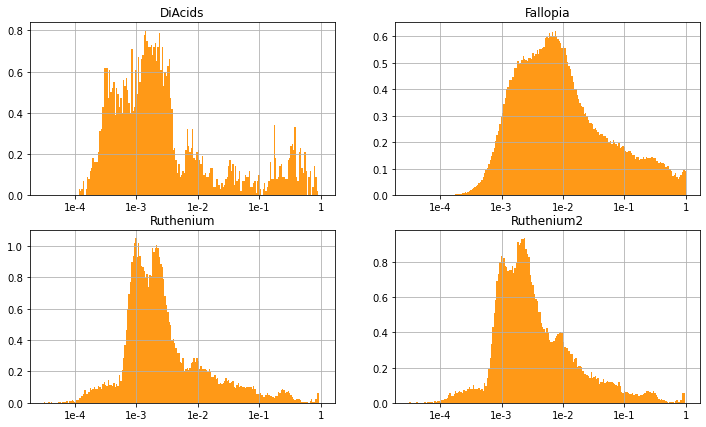

In [19]:
plt.figure(figsize = (12, 7))

for i in range(4):
    plt.subplot(2, 2, i + 1)
    histo_ir_norm(data["peaks"][sample_names[i]], sample_names[i])

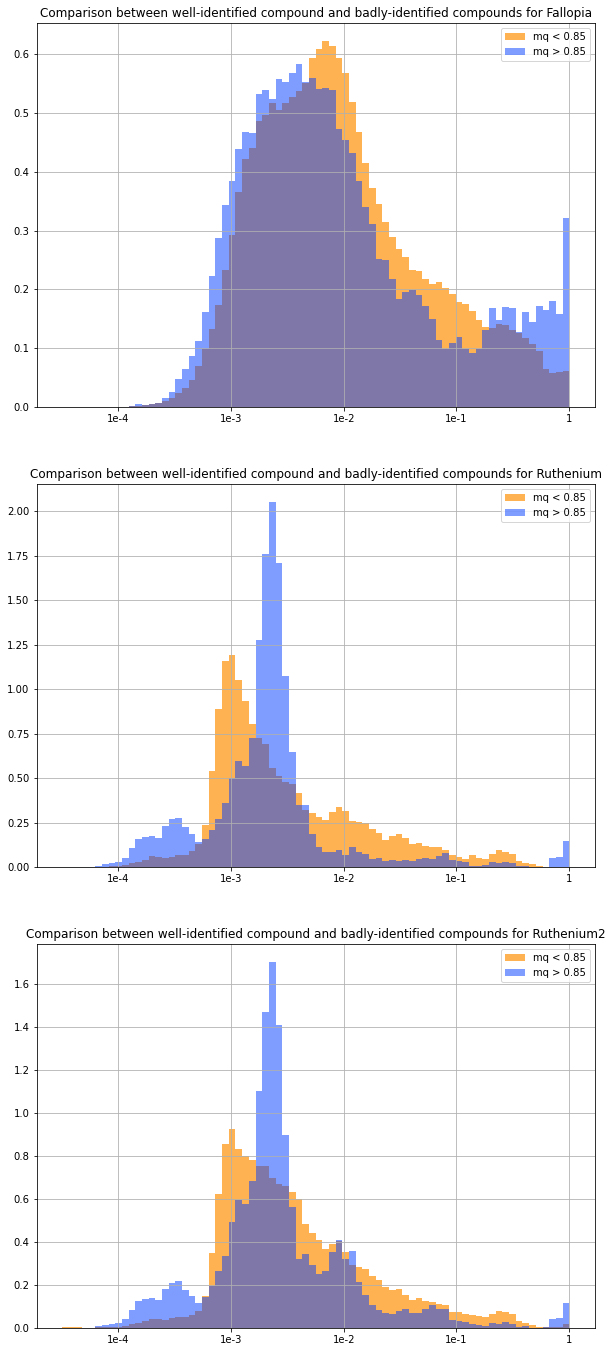

In [20]:
plt.figure(figsize = (10, 24))

for i in range(1, 4):
    plt.subplot(3, 1, i)
    compare_wrt_mq_norm(sample_names[i], lowmq_column = "all_lowmq")

In [21]:
def histo_fi_norm(df, title = "",  xmin = -4.5, bins = 200, show = False, border = False, grid = True, color = "#FF9917", alpha = 1, label = ""):
    """Plots an histogram of the count of intratio values in #bins intervals evenly spaced in logarithmic scale, starting from 10^-xmin. If precise_ticks is set to True, manage the ticks of the x-axis so it coincides with the edges of the bars in the histogram. If center_ticks is set to True, the labels will be displayed at the center of the bins instead of at the edges."""
    
    #Generates the list of values delimiting the intervals.
    xmin = np.log(250) / np.log(10)
    xmax = np.log(df["intensity"].max())/ np.log(10)
    splits = np.linspace(xmin, xmax, bins + 1)
    
    #Generate the plot in color (default : orange) with or without black borders (default : without)
    if border:
        bcolor = "#000000"
    else:
        bcolor = None
    
    sery = np.log(df["intensity"]) / np.log(10)
    sery.hist(bins = splits,
              grid = grid,
              color = color,
              edgecolor = bcolor,
              alpha = alpha,
              label = label,
              density = True)
    
    
    #Last aesthetic adjustments.
    ticks = np.linspace(int(xmin) + 1, int(xmax) + 1, 22) - .2
    plt.xticks(ticks)
    
    ax = plt.gca()
    ax.set_xticklabels(np.array([np.format_float_scientific(10 ** x,
                                                            precision = 1,
                                                            exp_digits = 1) for x in ticks]))
    ax.xaxis.set_minor_locator(tk.NullLocator())
    
    if title:
        plt.title(title)

  
    
def compare_histo_fi_norm(df1, df2, title = "", bins = 76, label1 = "df1", label2 = "df2"):
    """Plots on the same graphic the peaks size histograms for df1 in orange and df2 in blue."""
    histo_fi_norm(df1, bins = bins, alpha = .75, label = label1)
    histo_fi_norm(df2, bins = bins, color = "#003DFF", alpha = .5, label = label2)
    plt.legend()
    
    if title:
        plt.title(title)

def compare_fi_wrt_mq_norm(sample, lowmq_column = "lowmq"):
    compare_histo_fi_norm(mq_groups[lowmq_column][sample],
                  mq_groups["highmq"][sample],
                  title = "Comparison between well-identified compound and badly-identified compounds for " + sample,
                  label1 = "mq < 0.85",
                  label2 = "mq > 0.85"
                 )

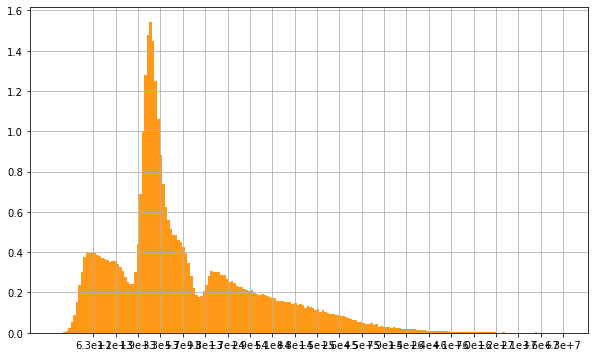

In [22]:
plt.figure(figsize = (10, 6))
histo_fi_norm(data["peaks"]["Fallopia"])

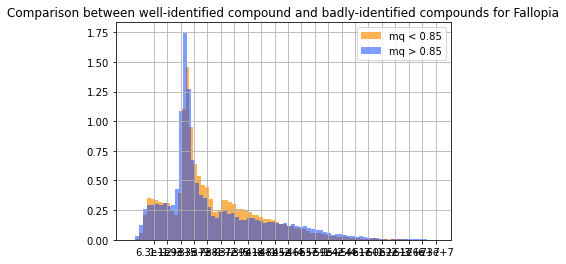

In [23]:
compare_fi_wrt_mq_norm("Fallopia")

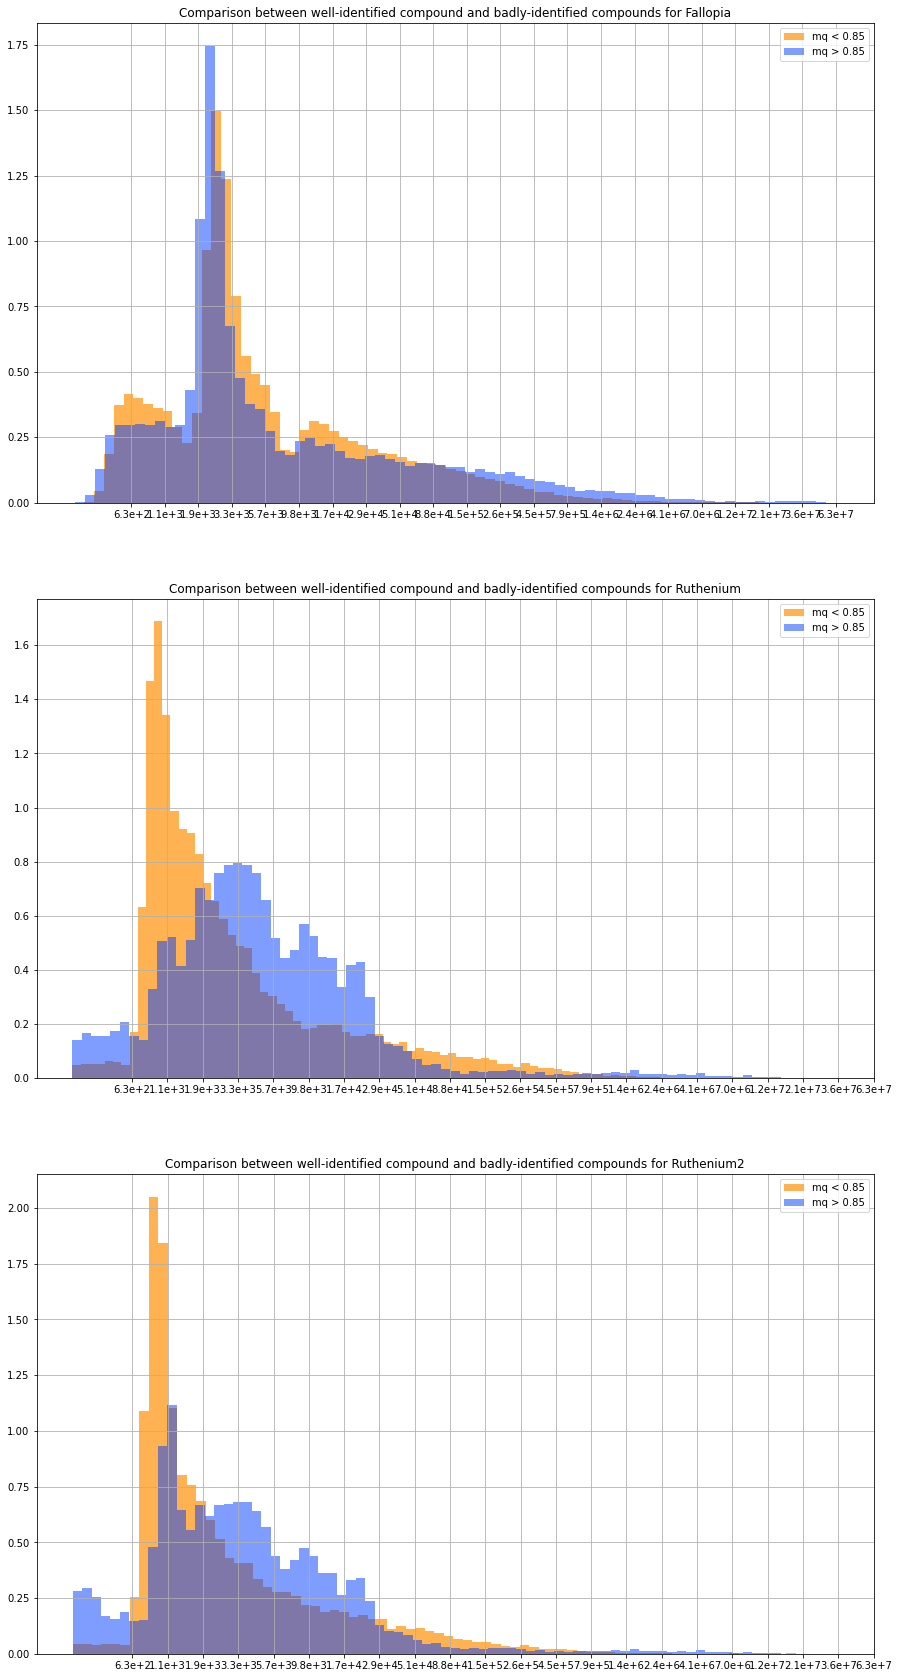

In [24]:
plt.figure(figsize = (15, 30))

for i in range(1, 4):
    plt.subplot(3, 1, i)
    compare_fi_wrt_mq_norm(sample_names[i], lowmq_column = "all_lowmq")